In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('data/diabetes.csv')
print(df.head())
print(df.describe())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   

In [3]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Split features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']


Missing Values:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [4]:
# Train-Test-Validation split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}, Test set size: {len(X_test)}")

Training set size: 460, Validation set size: 154, Test set size: 154


In [5]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training set and transform
X_val = scaler.transform(X_val)         # Transform validation set
X_test = scaler.transform(X_test)       # Transform test set

In [6]:
# Define base models
base_models = [
    ('logistic_regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgboost', XGBClassifier(eval_metric="logloss", random_state=42))
]

In [7]:
# Train individual models and evaluate on validation set
results = {}
for name, model in base_models:
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    results[name] = {
        "model": model,
        "accuracy": val_accuracy,
        "confusion_matrix": confusion_matrix(y_val, y_val_pred),
        "classification_report": classification_report(y_val, y_val_pred, output_dict=True)
    }
    print(f"{name} Validation Accuracy: {val_accuracy:.4f}")

logistic_regression Validation Accuracy: 0.7662
random_forest Validation Accuracy: 0.7662
xgboost Validation Accuracy: 0.7597


In [8]:
#Hyperparamete Tuning
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier(eval_metric="logloss", random_state=42)

# Define the parameter grid for XGBoost
param_dist_xgb = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 6, 9],  # Max depth of each tree
    'subsample': [0.8, 0.9, 1.0],  # Fraction of samples to train each tree
    'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features to use for each tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
}

# Perform RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist_xgb, n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

# Get the best model and hyperparameters
best_xgb_model = random_search_xgb.best_estimator_
print(f"Best XGBoost Model: {random_search_xgb.best_params_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best XGBoost Model: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [9]:
# Define the meta-model
meta_model = LogisticRegression(max_iter=1000, random_state=42)

# Create Stacking Classifier (with cross-validation on the training set)
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [10]:
# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Evaluate stacking ensemble on validation set
y_val_pred_stacking = stacking_model.predict(X_val)
stacking_val_accuracy = accuracy_score(y_val, y_val_pred_stacking)

# Add stacking results
results['Stacking Ensemble'] = {
    "model": stacking_model,
    "accuracy": stacking_val_accuracy,
    "confusion_matrix": confusion_matrix(y_val, y_val_pred_stacking),
    "classification_report": classification_report(y_val, y_val_pred_stacking, output_dict=True)
}

In [11]:
# Final evaluation on the test set
print("\nFinal Evaluation on the Test Set:")
y_test_pred_stacking = stacking_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred_stacking)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred_stacking)
test_classification_report = classification_report(y_test, y_test_pred_stacking)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Confusion Matrix:\n{test_confusion_matrix}")
print(f"Classification Report:\n{test_classification_report}")


Final Evaluation on the Test Set:
Test Accuracy: 0.7597
Confusion Matrix:
[[86 16]
 [21 31]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       102
           1       0.66      0.60      0.63        52

    accuracy                           0.76       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.76      0.76      0.76       154



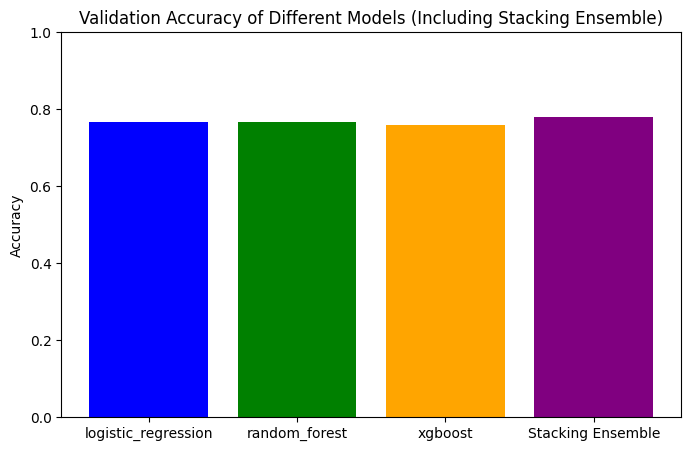

In [12]:
# Visualization of Validation Results
plt.figure(figsize=(8, 5))
model_names = list(results.keys())
accuracies = [results[model]['accuracy'] for model in model_names]
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'purple'])
plt.title("Validation Accuracy of Different Models (Including Stacking Ensemble)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

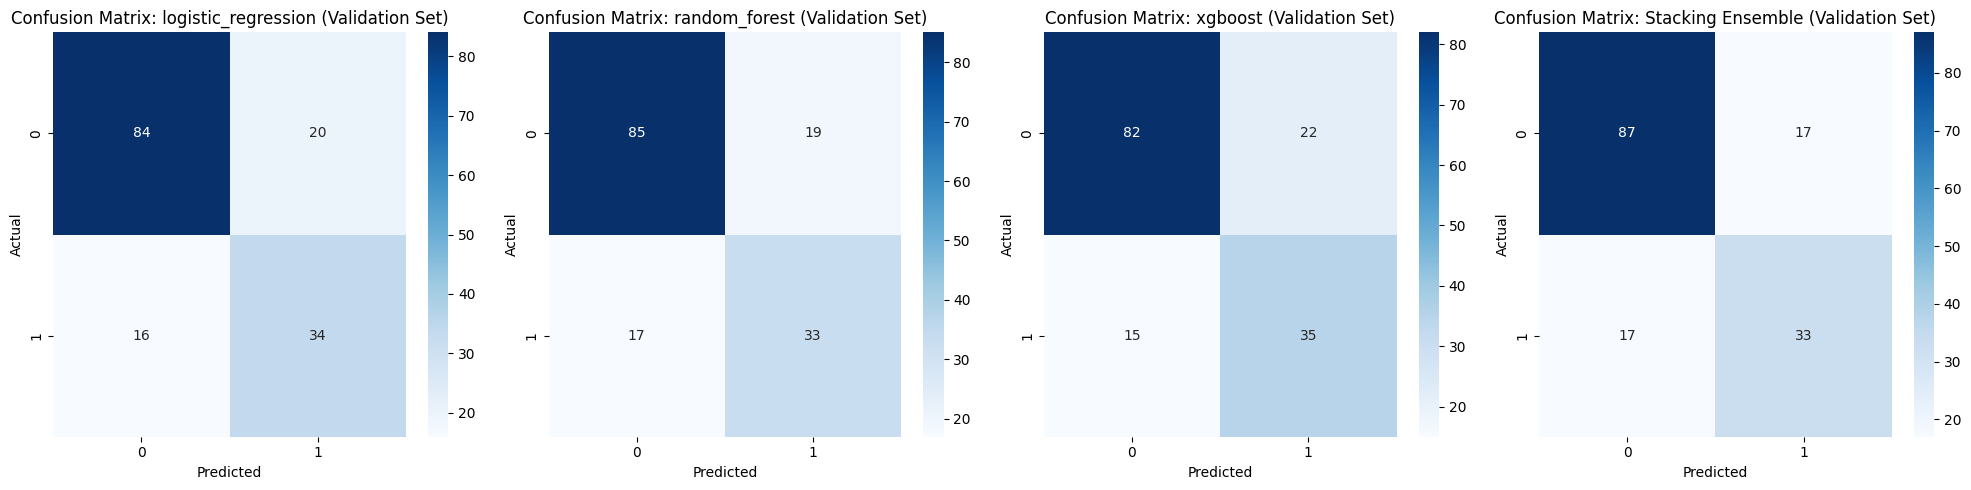

In [13]:
# Confusion Matrix Visualization (Validation Set)
plt.figure(figsize=(20, 5))
for i, model_name in enumerate(model_names):
    plt.subplot(1, len(model_names), i + 1)
    sns.heatmap(results[model_name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name} (Validation Set)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

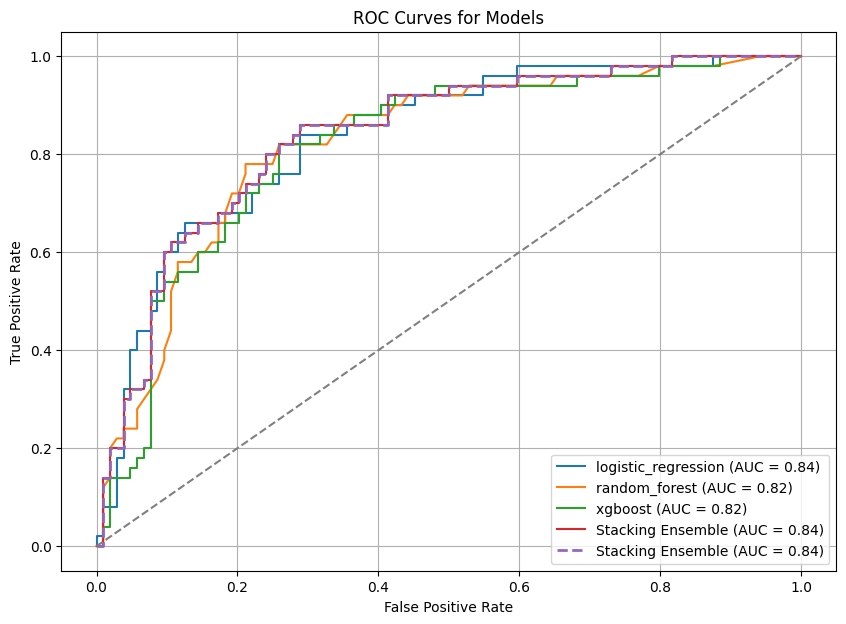

In [14]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for all models
plt.figure(figsize=(10, 7))

for name, result in results.items():
    model = result['model']
    y_val_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_val_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Add Stacking Ensemble ROC Curve
stacking_proba = stacking_model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, stacking_proba)
stacking_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Stacking Ensemble (AUC = {stacking_auc:.2f})", linestyle="--", linewidth=2)

# Plot random guess line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# ROC Curve formatting
plt.title("ROC Curves for Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()